In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import spacy
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Overview
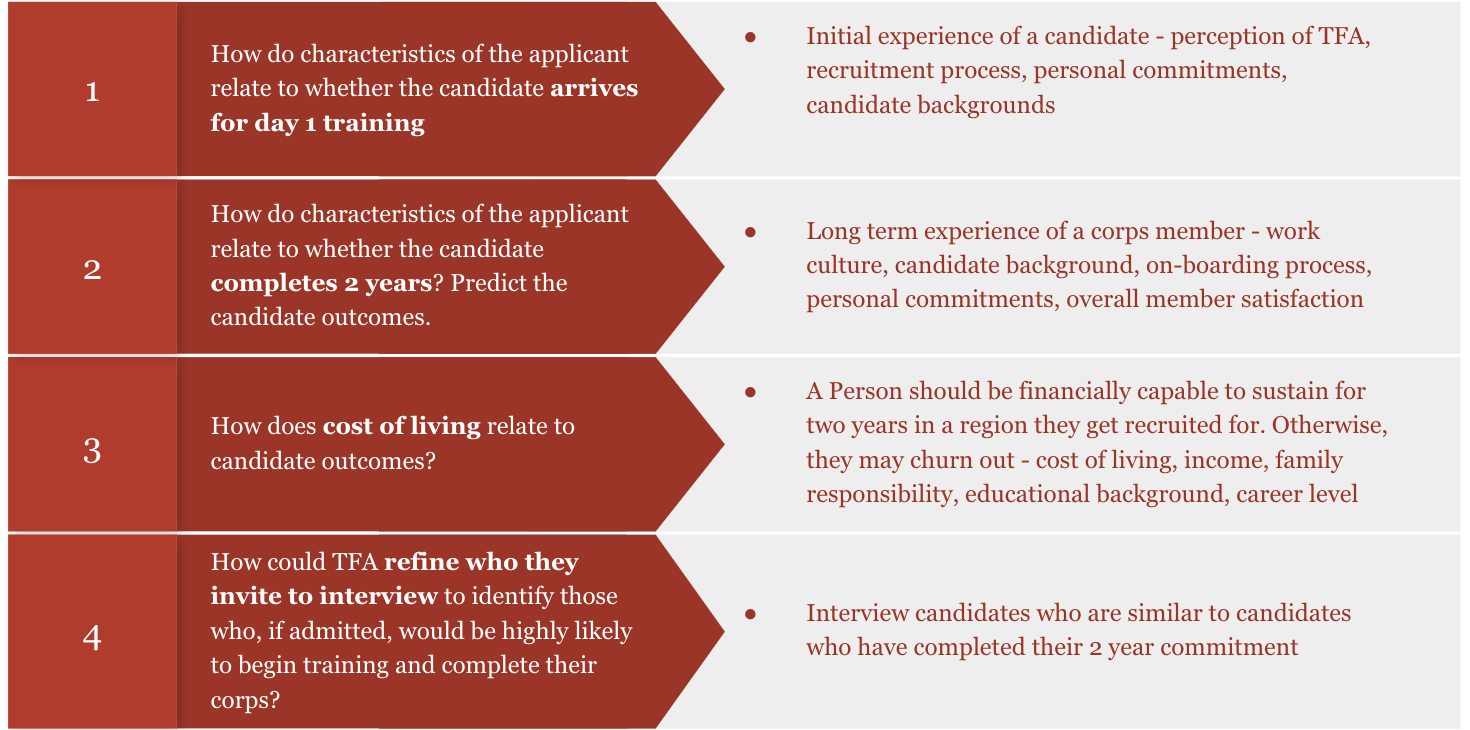

**Part 1: Turning up for first day training - Factors**

- Dataset: Candidates who are recruited
- Target variable: Progress_5_Start_1stDay
- Problem Type: Binary classification for feature importance
- Function Class: Logistic Regression - a statistical model that uses a logistic function to model a binary dependent variable based on one or more independent variables.
- Methodology:

  Step 1: Data Cleaning - Handling missing data, Handling categorical variables (Nominal & Ordinal)

  Step 2: Feature Engineering

  Step 3: Exploratory Data Analysis

  Step 4: Data Preprocessing

  Step 5: Modeling - Model selection (cross validation), Training, Hyperparameter tuning, Predicting, Evaluating

  Step 6: Visualizations

- Model Performance (Intrinsic metrics): 81.5% accuracy
- Findings: Top 4 features driving candidates to turn up on day 1: Teach region, UG school, UG major group, UG stem

  Teach region: Certain regions like NYC, BAYAREA, BOSTON, MEMPHIS show an increasing gap between the number of candidates who turned up for day 1 training Vs candidates who did not.

  UG school, UG major group, UG stem: Candidates from a certain educational backgrounds like particular school, majors and particularly non-stem disciplines tend to turn up for the day 1 training more than the others.


**Part 2: Two yearr outcome - Factors & Prediction**
- Dataset: Candidates who are recruited
- Target variable: Progress_6_Complete_2yrs
- Problem Type: Binary classification
- Function Class: XGBoost - machine learning algorithm that uses an ensemble of decision trees to make predictions while optimizing a gradient boosting objective.
- Methodology:

  Step 1: Data acquisition- Merging regional costs data with candidates data for a holistic analysis

  Step 2: Data Cleaning - Handling missing data, Handling categorical variables (Nominal & Ordinal)

  Step 3: Feature Engineering

  Step 4: Exploratory Data Analysis

  Step 5: Data Preprocessing

  Step 6: Modeling - Model selection (cross validation), Training, Hyperparameter tuning, Predicting, Evaluating

  Step 7: Visualizations

- Model Performance (Intrinsic metrics): 75.8% accuracy
  Precision: 0.81
  Recall: 0.75
  F1 core: 0.75

- Further analysis: Candidate clusters - Different candidates have different potential, interests and needs - if those interests and needs are addressed, people will stick by. Hence we study these clusters to make data driven recommendations.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Data_folder/WPAC_2023_CandidateRecords (1).csv')
#7 years candidate level - The dataset includes all candidates that applied including candidates that applied, but were not accepted to TFA
data.head()

EDA

In [ ]:
#NAs are important, we want to drop NAs that are irrelevant but keep those that represent an important aspect of the data.
#Since Progress_1_Invite_Intrvw has no nulls, the entire dataset is important.
print((data.isnull().sum()*100/data.shape[0]).round(2))
print('% candidates invited for the first round',data[data['Progress_1_Invite_Intrvw']==True].shape[0]*100/data.shape[0])
print('% candidates completed the first round',data[data['Progress_2_Complete_Intrvw']==True].shape[0]*100/data.shape[0])
print('% candidates accepted',data[data['Progress_3_Accepted_toCorp']==True].shape[0]*100/data.shape[0])
print('% candidates confirm offer',data[data['Progress_4_Comfirm_Offer']==True].shape[0]*100/data.shape[0])
print('% candidates turning up on day1',data[data['Progress_5_Start_1stDay']==True].shape[0]*100/data.shape[0])
print('% candidates who completed 2 years',data[data['Progress_6_Complete_2yrs']=='TRUE'].shape[0]*100/data.shape[0])
#data.dropna('')

In [ ]:
print('#candidates invited for the first round',data[data['Progress_1_Invite_Intrvw']==True].shape[0])
print('#candidates completed the first round',data[data['Progress_2_Complete_Intrvw']==True].shape[0])
print('#candidates accepted',data[data['Progress_3_Accepted_toCorp']==True].shape[0])
print('#candidates confirm offer',data[data['Progress_4_Comfirm_Offer']==True].shape[0])
print('#candidates turning up on day1',data[data['Progress_5_Start_1stDay']==True].shape[0])
print('#candidates who completed 2 years',data[data['Progress_6_Complete_2yrs']=='TRUE'].shape[0])

Q1. Part1

How do characteristics of the applicant relate to whether the candidate arrives for Day 1 training

In [ ]:
#We want to look at the recruited candidates only
data1=data[data['Progress_3_Accepted_toCorp']==True]
X_part1=data1.drop(['Progress_1_Invite_Intrvw','Progress_2_Complete_Intrvw','Progress_3_Accepted_toCorp','Progress_4_Comfirm_Offer','Progress_5_Start_1stDay','Progress_6_Complete_2yrs'], axis=1)
data1['Progress_5_Start_1stDay']=data1['Progress_5_Start_1stDay'].apply(lambda x: 1 if x==True else 0)
y_part1=data1['Progress_5_Start_1stDay'].astype('category')

Q1. Part2

How do characteristics of the applicant relate to whether the candidate completes the program through Year 2?

From information available to TFA before the final interview, predict the candidate outcomes at Year 2.

In [ ]:
regions=pd.read_csv('/content/drive/MyDrive/Data_folder/Region_Cost.csv')
r1=regions.set_index('Region').stack().reset_index(name='col').rename(columns={'level_1':'year'})
r1.head()

In [ ]:
# Because we want to see long term outcomes, it will be a good idea to incorporate cost of living in our dataset for this part
r1['year']=r1['year'].astype(int)
data_merged=pd.merge(data,r1,how='left',left_on=['Teach_region','App_year'], right_on=['Region','year'])
data_merged.drop(['year','Region'], axis=1, inplace=True)
data_merged.head()

In [ ]:
#We want to look at the recruited candidates
print('no. of rows where our target variable is null',data_merged[data_merged['Progress_6_Complete_2yrs'].isnull()].shape[0])
#Progress_6_Complete_2yrs null should not be used for making prediction as these could be data points missing due to no information.
data_merged['Progress_6_Complete_2yrs']=data_merged['Progress_6_Complete_2yrs'].apply(lambda x: 1 if x=='TRUE' else( 0 if x=='FALSE' else -1))
#data['Progress_6_Complete_2yrs']=data['Progress_6_Complete_2yrs'].apply(lambda x: 1 if x=='TRUE' else 0)
data2=data_merged[(data_merged['Progress_6_Complete_2yrs']!=-1) & (data_merged['Progress_3_Accepted_toCorp']==True)]
#data2=data[data['Progress_3_Accepted_toCorp']==True]
X_part2=data2.drop(['Progress_1_Invite_Intrvw','Progress_2_Complete_Intrvw','Progress_3_Accepted_toCorp','Progress_4_Comfirm_Offer','Progress_5_Start_1stDay','Progress_6_Complete_2yrs'], axis=1)
y_part2=data2['Progress_6_Complete_2yrs'].astype('category')

In [ ]:
from sklearn.model_selection import train_test_split
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_part1, y_part1, test_size=0.3, random_state=42)
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(X_part2, y_part2, test_size=0.3, random_state=42)

In [ ]:
print((data[data['Progress_5_Start_1stDay']==True].isnull().sum()*100/data[data['Progress_5_Start_1stDay']==True].shape[0]).round(2))
#We should drop selection dimensions as its 84% null even for candidates who were recruited
#For the rest columns, we handle nulls in numerical and cat columns separately

In [ ]:
def feature_eng(data):
  #Creating new meaningful features from the existing ones
  data['App_year']=data['App_year'].astype('category')
  data['App_submit_date']=pd.to_datetime(data['App_submit_date'])
  data['App_start_date']=pd.to_datetime(data['App_start_date'])
  data['ComfirmOffer_date']=pd.to_datetime(data['ComfirmOffer_date'])
  data['app_prep_time']=(data['App_submit_date']-data['App_start_date']).dt.days
  data['app_processing_time']=(data['ComfirmOffer_date']-data['App_submit_date']).dt.days
  data=data.drop(['user_ID','App_submit_date','App_start_date','ComfirmOffer_date'], axis=1)
  data=data.drop(['SelectionDimension_1','SelectionDimension_2','SelectionDimension_3','SelectionDimension_4'], axis=1)

  cols = data.columns
  num_cols = data._get_numeric_data().columns
  cat_cols=list(set(cols) - set(num_cols))

  #Handling missing values
  for i in num_cols:
    data[i].fillna(0, inplace=True)

  for i in cat_cols:
    data[i]=data[i].astype('category')
    data[i].cat.add_categories(['NA'], inplace=True)
    data[i].fillna('NA', inplace=True)
    data[i]=data[i].astype('category')

  #Ordinal vs nominal
  data['career_level'].cat.reorder_categories(['NA','Junior','Co-terming Senior','Undergrad','Grad Student', 'Professional'], ordered=True, inplace=True)
  data['UG_school_selectivity'].cat.reorder_categories(['NA','Least Selective','Less Selective','Selective','More Selective', 'Most Selective'], ordered=True, inplace=True)
  data['UG_PellGrant'].cat.reorder_categories(['NA','NO','PARTIAL','MAXIMUM'], ordered=True, inplace=True)
  data['LIC_served_rating'].cat.reorder_categories(['NA','LEVEL1','LEVEL2','LEVEL3'], ordered=True, inplace=True)

  ordinal=[]
  nominal=[]
  for i in cat_cols:
    if data[i].cat.ordered:
      ordinal.append(i)
    else:
      nominal.append(i)


  return data, nominal, ordinal, cat_cols, num_cols


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class NamedOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        if self.columns is None:
            self.columns = X.columns
        self.encoder.fit(X[self.columns].to_numpy())
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X[self.columns] = self.encoder.transform(X[self.columns].to_numpy())
        return X

    def get_feature_names(self):
        return self.columns

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

def handle_ordinal_train(data,ordinal):
  enc= NamedOrdinalEncoder(columns=ordinal)
  ord_encoded = enc.fit_transform(data[ordinal])
  #data_ord_encoded = pd.DataFrame(ord_encoded, index=data.index)
  encoded_df = pd.DataFrame(ord_encoded, columns=enc.get_feature_names())
  data1 = pd.concat([data, encoded_df], axis=1)
  return data1, enc

def handle_ordinal_test(data,ordinal, enc):
  ord_encoded = enc.transform(data[ordinal])
  #data_ord_encoded = pd.DataFrame(ord_encoded, index=data.index)
  encoded_df = pd.DataFrame(ord_encoded, columns=enc.get_feature_names())
  data1 = pd.concat([data, encoded_df], axis=1)
  return data1

def handle_nominal_train(data,nominal):
  enc=OneHotEncoder(handle_unknown='ignore', sparse=False)
  nom_encoded = enc.fit_transform(data[nominal])
  encoded_df = pd.DataFrame(nom_encoded, columns=enc.get_feature_names(nominal))
  data1=pd.concat([data.reset_index(), encoded_df], axis='columns')
  # return data1
  # dummies = pd.get_dummies(data, columns=nominal)
  # data1 = pd.concat([data, dummies], axis=1)
  return data1, enc

def handle_nominal_test(data,nominal,enc):
  nom_encoded = enc.transform(data[nominal])
  encoded_df = pd.DataFrame(nom_encoded, columns=enc.get_feature_names(nominal))
  data1=pd.concat([data.reset_index(), encoded_df], axis='columns')
  # return data1
  # dummies = pd.get_dummies(data, columns=nominal)
  # data1 = pd.concat([data, dummies], axis=1)
  return data1




In [ ]:
#Processing the data
def process_data_train(X):
  X_eng, nominal, ordinal, cat_cols, num_cols =feature_eng(X)
  X_ord, ord_enc=handle_ordinal_train(X_eng,ordinal)
  X_nom, nom_enc=handle_nominal_train(X_ord,nominal)
  X_out=X_nom.drop(cat_cols, axis=1)
  print(X_out.shape)
  return X_out, ord_enc, nom_enc, num_cols

def process_data_test(X,ord_enc, nom_enc):
  X_eng, nominal, ordinal, cat_cols, num_cols =feature_eng(X)
  X_ord = handle_ordinal_test(X_eng,ordinal,ord_enc)
  X_nom = handle_nominal_test(X_ord,nominal,nom_enc)
  X_out=X_nom.drop(cat_cols, axis=1)
  print(X_out.shape)
  return X_out


In [ ]:
def get_score(model, X, y):
  pred = model.predict(X)
  cf_rep = pd.DataFrame(classification_report(y, pred, output_dict=True))
  cm=confusion_matrix(y,pred)
  print("Accuracy Score:\n", (accuracy_score(y, pred) * 100).round(2))
  print("Classification report:\n",cf_rep)
  print("Confusion Matrix:\n",cm)

def model_build(model, x_train, y_train, x_test, y_test, num_cols):
  vec = ColumnTransformer([('sc', StandardScaler(), num_cols)], remainder='passthrough')
  x_train1=vec.fit_transform(x_train)
  x_test1=vec.transform(x_test)
  model.fit(x_train1, y_train)
  get_score(model, x_test1, y_test)
  return model

In [ ]:
y_train_pl.info()

Checking if data is balanced -Imbalanced datasets can make it very hard for a model to predict accurately

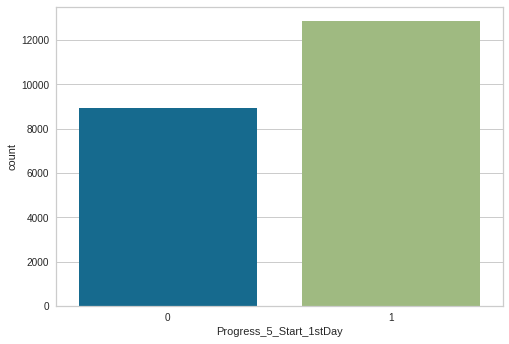

In [ ]:
import seaborn as sns
sns.countplot(y_train_p1)

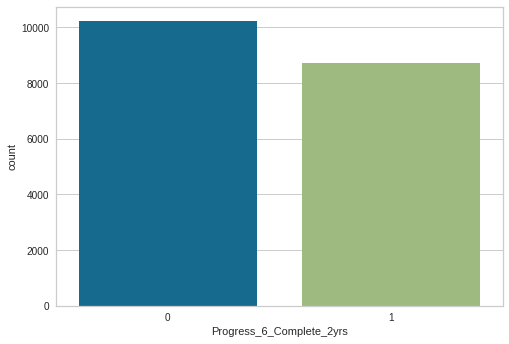

In [ ]:
sns.countplot(y_train_p2)

In [ ]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_train2, y_train1 = oversample.fit_resample (X_train1.values, y_train.values)
# # summarize the new class distribution
# sns.countplot(y_train1)

# Part 1 results

Data Pre-processing

In [ ]:
X_train1,ord_enc, nom_enc, num_cols =process_data_train(X_train_p1)
X_train1.drop('index',axis=1,inplace=True)
X_test1=process_data_test(X_test_p1,ord_enc, nom_enc)
X_test1.drop('index',axis=1,inplace=True)

(21793, 329)
(9341, 329)


# Decision Tree
- They do not require scaling or normalizing the data because decision trees are not sensitive to the scale of the features
- Tendancy to overfit

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dec_tree = DecisionTreeClassifier(random_state=21)
dec_tree.fit(X_train1, y_train_p1)


DecisionTreeClassifier(random_state=21)

In [ ]:
get_score(dec_tree, X_train1, y_train_p1)

Accuracy Score:
 100.0
Classification report:
                 0        1  accuracy  macro avg  weighted avg
precision     1.0      1.0       1.0        1.0           1.0
recall        1.0      1.0       1.0        1.0           1.0
f1-score      1.0      1.0       1.0        1.0           1.0
support    8933.0  12860.0       1.0    21793.0       21793.0
Confusion Matrix:
 [[ 8933     0]
 [    0 12860]]


In [ ]:
get_score(dec_tree, X_test1, y_test_p1)

Accuracy Score:
 75.23
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.695265     0.791772  0.752275     0.743519      0.752440
recall        0.698188     0.789483  0.752275     0.743835      0.752275
f1-score      0.696723     0.790626  0.752275     0.743675      0.752355
support    3807.000000  5534.000000  0.752275  9341.000000   9341.000000
Confusion Matrix:
 [[2658 1149]
 [1165 4369]]


Decision Tree is clearly overfitting, with a very high train accuracy Vs a very low test accuracy

In [ ]:
# from IPython.display import Image
# from six import StringIO
# from sklearn.tree import export_graphviz
# import pydot

# features = list(X_train1.columns)

# dot_data = StringIO()
# export_graphviz(dec_tree, out_file=dot_data, feature_names=features, filled=True)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())
# Image(graph[0].create_png())

# Logistic Regression
- Lower tendancy to overfit

In [ ]:
log_reg=model_build(LogisticRegression(random_state=42), X_train1, y_train_p1, X_test1, y_test_p1, num_cols)

Accuracy Score:
 81.44
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.976990     0.765067  0.814367     0.871029      0.851438
recall        0.557657     0.990965  0.814367     0.774311      0.814367
f1-score      0.710033     0.863486  0.814367     0.786760      0.800945
support    3807.000000  5534.000000  0.814367  9341.000000   9341.000000
Confusion Matrix:
 [[2123 1684]
 [  50 5484]]


In [ ]:
data1['App_submit_date']=pd.to_datetime(data1['App_submit_date'])
data1['App_start_date']=pd.to_datetime(data1['App_start_date'])
data1['ComfirmOffer_date']=pd.to_datetime(data1['App_start_date'])
data1['app_processing_time']=(data1['ComfirmOffer_date']-data1['App_submit_date']).dt.days
data1['app_prep_time']=(data1['App_submit_date']-data1['App_start_date']).dt.days

In [ ]:
# coef = log_reg.coef_[0]
# sorted_coef = np.argsort(coef)[::-1]
# features = X_train1.columns
# ordered_features = features[sorted_coef]
# ordered_features
feat_importances = pd.DataFrame(log_reg.coef_[0], index=X_train1.columns).reset_index().sort_values(0,ascending=False)[:200]
feat_importances['index']=feat_importances['index'].apply(lambda x: "_".join(x.split("_")[:-1]) if x not in data1.columns else x)
f1=feat_importances.groupby('index').mean()[0].reset_index().sort_values(0, ascending=False)
f1

,index,0
4,Teach_region,0.363823
9,UG_school_name,0.270564
6,UG_major_byGroup,0.237224
8,UG_major_minor_STEM,0.227625
3,Match_region,0.194916
10,UG_sports,0.183045
7,UG_major_bySchool,0.140609
5,Teach_subject,0.109737
1,LIC_served_self_report,0.101277
12,family_responsibility,0.088868


<BarContainer object of 13 artists>

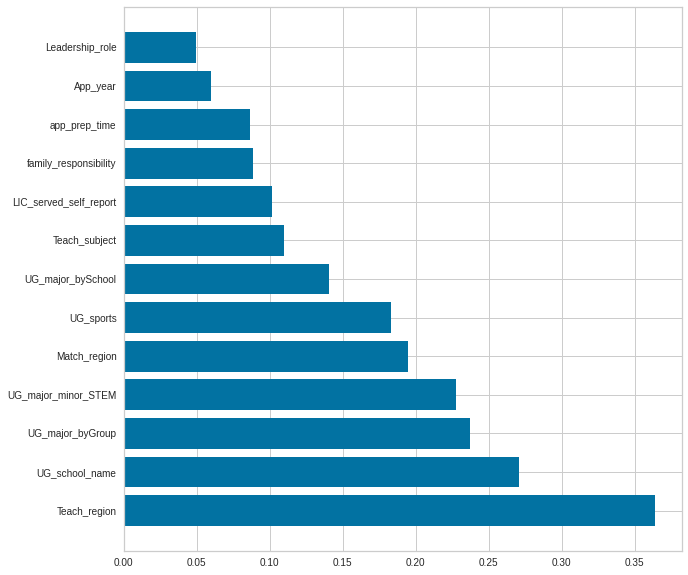

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(f1['index'], f1[0])

Logistic regression does well on both train and test sets, lets try to tune it further to increase the accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'solver' : ['lbfgs','liblinear','saga'],
    'max_iter' : [1000,2000]
    }
]
log_reg1= LogisticRegression()
log_reg_tuned= GridSearchCV(log_reg1, param_grid = param_grid, cv = 2, verbose=True)
log_reg_tuned=log_reg_tuned.fit(X_train1, y_train_p1)
log_reg_tuned.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits


LogisticRegression(max_iter=2000, solver='saga')

In [ ]:
log_reg2= LogisticRegression(max_iter=2500, solver='saga', penalty='l1')
log_reg2.fit(X_train1, y_train_p1)
get_score(log_reg2, X_test1, y_test_p1)

Accuracy Score:
 81.54
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     1.000000     0.762469  0.815437     0.881234      0.859277
recall        0.547150     1.000000  0.815437     0.773575      0.815437
f1-score      0.707301     0.865228  0.815437     0.786264      0.800864
support    3807.000000  5534.000000  0.815437  9341.000000   9341.000000
Confusion Matrix:
 [[2083 1724]
 [   0 5534]]


[Text(0, 0.5, 'Number of applicants who turned up for Day1 training'),
 Text(0.5, 0, 'Regions')]

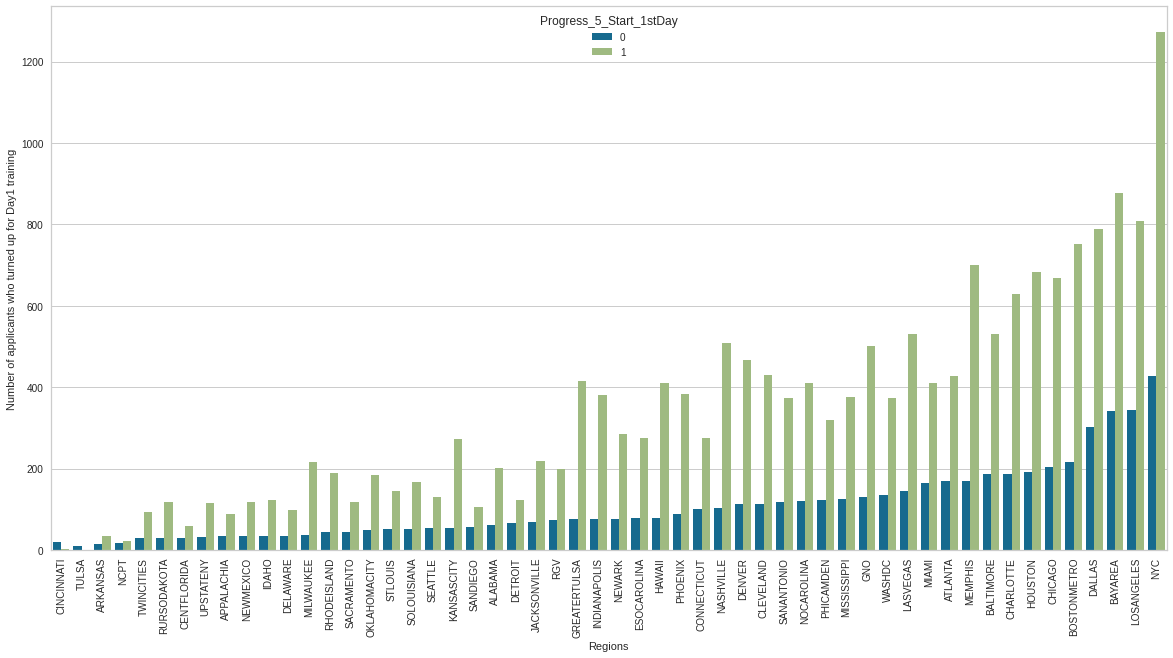

In [ ]:
df=data1.groupby(['Teach_region','Progress_5_Start_1stDay']).count()['App_start_date'].reset_index().sort_values('App_start_date', ascending=True)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
ax=sns.barplot(data=df, x='Teach_region', y='App_start_date', hue='Progress_5_Start_1stDay')
ax.set(xlabel='Regions', ylabel='Number of applicants who turned up for Day1 training')

[Text(0, 0.5, 'Number of applicants who turned up for Day1 training'),
 Text(0.5, 0, 'Schools')]

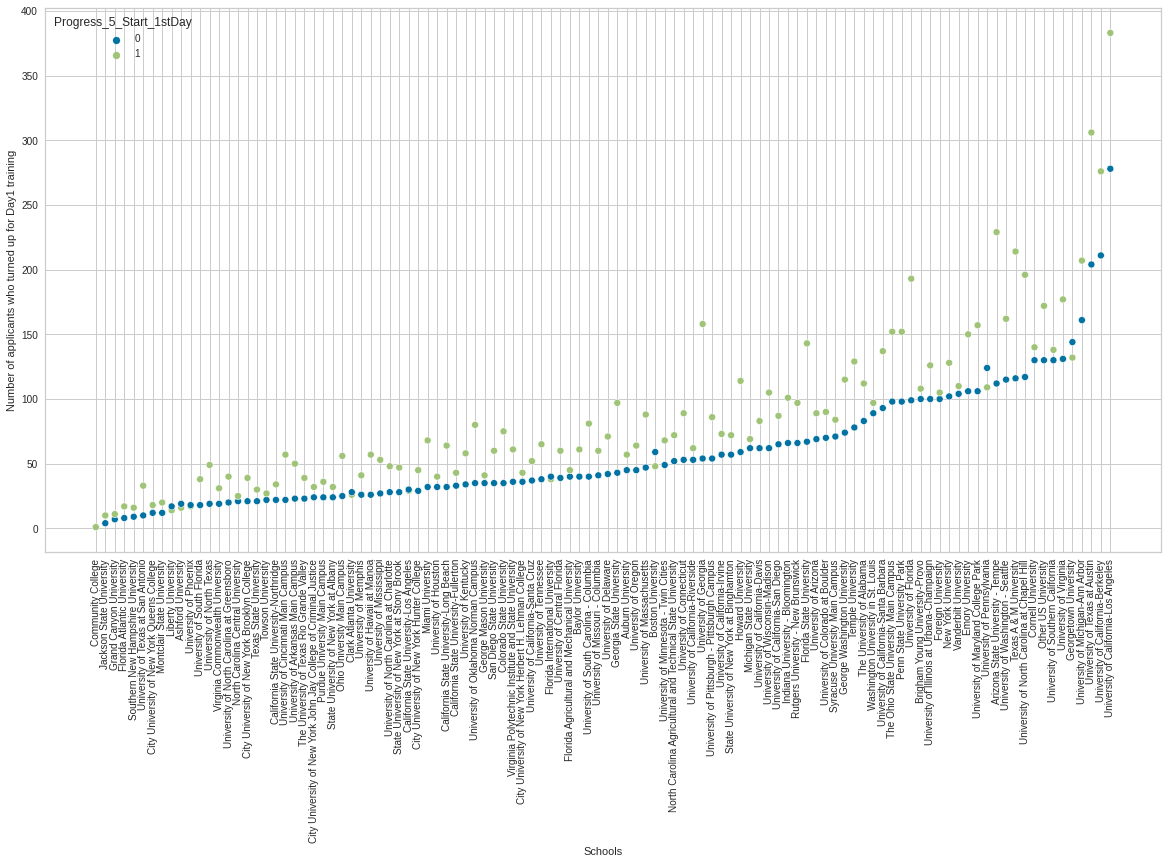

In [ ]:
df=data1[data1['UG_school_name']!='other'].groupby(['UG_school_name','Progress_5_Start_1stDay']).count()['App_start_date'].reset_index().sort_values('App_start_date', ascending=True)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
#ax=sns.boxplot(data=df, x='UG_school_name', y='App_start_date',hue='Progress_5_Start_1stDay')
ax=sns.scatterplot(data=df, x="UG_school_name", y="App_start_date", hue="Progress_5_Start_1stDay")
ax.set(xlabel='Schools', ylabel='Number of applicants who turned up for Day1 training')

In [ ]:
df=data1.groupby(['UG_major_byGroup','Progress_5_Start_1stDay']).count()['App_start_date'].reset_index().sort_values('App_start_date', ascending=True)
df1=df[df['Progress_5_Start_1stDay']==0]
df1['percent']=df1['App_start_date']/df1['App_start_date'].sum()
df2=df1.sort_values('percent', ascending=False)
df4=df2.head(50)
df4.loc[len(df4.index)] = ['Others', df2[50:].sum()[1],df2[50:].sum()[2],df2[50:].sum()[3]]
# ax=sns.lineplot(data=df, x='UG_major_byGroup', y='App_start_date',hue='Progress_5_Start_1stDay')
# ax.set(xlabel='UG major group', ylabel='Number of applicants who turned up for Day1 training')
# df1
fig = px.pie(df4,values="percent", names="UG_major_byGroup", title='Dropped off candidates by UG major', hover_data=['App_start_date'])
fig.show(renderer = 'colab')

[Text(0, 0.5, 'Number of applicants who turned up for Day1 training'),
 Text(0.5, 0, 'STEM MAJOR')]

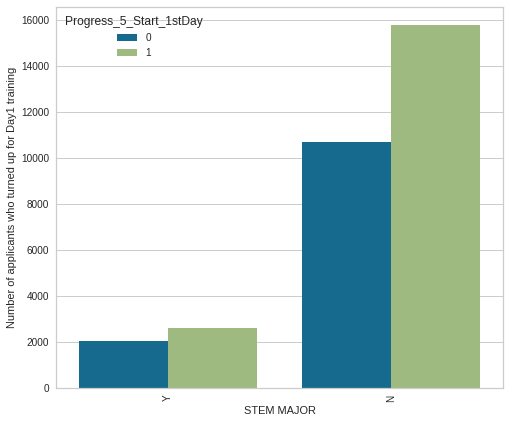

In [ ]:
plt.figure(figsize=(8,7))
plt.xticks(rotation=90)
df=data1.groupby(['UG_major_minor_STEM','Progress_5_Start_1stDay']).count()['App_start_date'].reset_index().sort_values('App_start_date', ascending=True)
ax=sns.barplot(data=df, x='UG_major_minor_STEM', y='App_start_date',hue='Progress_5_Start_1stDay')
ax.set(xlabel='STEM MAJOR', ylabel='Number of applicants who turned up for Day1 training')

In [ ]:
df=data1.groupby(['Teach_region','UG_school_name','UG_major_byGroup','UG_major_minor_STEM','Progress_5_Start_1stDay']).count()['App_start_date'].reset_index(name='counts').sort_values('counts', ascending=False)
converted_cand_imp_traits=df[df['Progress_5_Start_1stDay']==1]
dropped_cand_imp_traits=df[df['Progress_5_Start_1stDay']==0]
#Got recruited and completed day 1 training
converted_cand_imp_traits.head(10)

,Teach_region,UG_school_name,UG_major_byGroup,UG_major_minor_STEM,Progress_5_Start_1stDay,counts
10464,NYC,other,Psychology,N,1,77
1926,BOSTONMETRO,other,Psychology,N,1,53
10462,NYC,other,Political Science,N,1,51
1540,BAYAREA,other,Psychology,N,1,51
1924,BOSTONMETRO,other,Political Science,N,1,48
10421,NYC,other,English,N,1,44
2801,CHICAGO,other,Psychology,N,1,43
2799,CHICAGO,other,Political Science,N,1,43
9750,NOCAROLINA,other,Psychology,N,1,37
8063,MEMPHIS,other,Political Science,N,1,36


In [ ]:
#Got recruited and didnot turn up for day 1 training
dropped_cand_imp_traits.head(10)

,Teach_region,UG_school_name,UG_major_byGroup,UG_major_minor_STEM,Progress_5_Start_1stDay,counts
10420,NYC,other,English,N,0,24
10461,NYC,other,Political Science,N,0,17
10463,NYC,other,Psychology,N,0,17
2800,CHICAGO,other,Psychology,N,0,17
3900,DALLAS,other,Psychology,N,0,15
7600,LOSANGELES,other,Psychology,N,0,14
1923,BOSTONMETRO,other,Political Science,N,0,14
10392,NYC,other,Biological science,Y,0,13
2798,CHICAGO,other,Political Science,N,0,12
1537,BAYAREA,other,Political Science,N,0,12


# Part 2 results

In [ ]:
X_train1,ord_enc, nom_enc, num_cols =process_data_train(X_train_p2)
X_train1.drop('index',axis=1,inplace=True)
X_test1=process_data_test(X_test_p2,ord_enc, nom_enc)
X_test1.drop('index',axis=1,inplace=True)

(18965, 329)
(8129, 329)


In [ ]:
def model_selection(num_cols,X_train2, y_train_p2):
  vec = ColumnTransformer([('sc', StandardScaler(), num_cols)], remainder='passthrough')
  rf = Pipeline([('transformer', vec), ('RandomForest', RandomForestClassifier(random_state = 42))])
  ada= Pipeline([('transformer', vec), ('Adaboost', AdaBoostClassifier(random_state = 42))])
  Et = Pipeline([('transformer', vec), ('ExtraTreeClassifier', ExtraTreesClassifier(random_state = 42))])
  Bgc = Pipeline([('transformer', vec), ('BaggingClassifier', BaggingClassifier(base_estimator = DecisionTreeClassifier(), random_state = 42))])
  Gb = Pipeline([('transformer', vec), ('GradientBoosting', GradientBoostingClassifier(random_state = 42))])
  knn = Pipeline([('transformer', vec), ('KNN', KNeighborsClassifier())])
  log_reg = Pipeline([('transformer', vec), ('LogisticRegression', LogisticRegression(random_state = 42))])
  sgd = Pipeline([('transformer', vec), ('StochasticGradient', SGDClassifier(random_state = 42))])
  naive_bayes= Pipeline([('transformer', vec), ('NaiveBayes', GaussianNB())])
  svc = Pipeline([('transformer', vec), ('SVM', SVC(random_state = 42))])
  lgbm = Pipeline([('transformer', vec), ('lightgbm', LGBMClassifier(random_state = 42))])
  xgb = Pipeline([('transformer', vec), ('XGBoost', XGBClassifier(random_state = 42))])
  models=[rf, ada, Et, Bgc, Gb, knn, log_reg, sgd, naive_bayes, svc,lgbm, xgb]
  models_dic={0:'rf', 1:'ada', 2:'Et', 3:'Bgc', 4:'Gb', 5:'knn', 6:'log_reg', 7:'sgd', 8:'naive_bayes', 9:'svc',10:'lgbm', 11:'xgb'}
  for i,j in enumerate(models):
      score = cross_val_score(j, X_train2, y_train_p2, cv = 5, scoring = 'accuracy')
      print(models_dic[i], ":", score.mean())

In [ ]:
model_selection(num_cols,X_train1, y_train_p2)

rf : 0.7572897442657527
ada : 0.7608225678882151
Et : 0.730872660163459
Bgc : 0.7218033219087794
Gb : 0.765199050883206
knn : 0.7038755602425522
log_reg : 0.745689427893488
sgd : 0.7435802794621672
naive_bayes : 0.7411020300553652
svc : 0.7508568415502241
lgbm : 0.7592934352755075
xgb : 0.7641972053783285


XGBoost, GradientBoosting, RF seem to fit the data the best

In [ ]:
rf_clf=model_build(RandomForestClassifier(random_state = 21), X_train1, y_train_p2, X_test1, y_test_p2, num_cols)

Accuracy Score:
 74.77
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.898453     0.660718  0.747693     0.779586      0.790011
recall        0.604388     0.918554  0.747693     0.761471      0.747693
f1-score      0.722650     0.768589  0.747693     0.745619      0.743605
support    4421.000000  3708.000000  0.747693  8129.000000   8129.000000
Confusion Matrix:
 [[2672 1749]
 [ 302 3406]]


In [ ]:
from numpy import array
xgb_clf=model_build(XGBClassifier(random_state = 21), X_train1, y_train_p2, X_test1, y_test_p2, num_cols)

Accuracy Score:
 75.52
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.966245     0.655560  0.755197     0.810902      0.824527
recall        0.569781     0.976268  0.755197     0.773024      0.755197
f1-score      0.716847     0.784399  0.755197     0.750623      0.747660
support    4421.000000  3708.000000  0.755197  8129.000000   8129.000000
Confusion Matrix:
 [[2519 1902]
 [  88 3620]]


In [ ]:
gb_clf=model_build(GradientBoostingClassifier(random_state = 21), X_train1, y_train_p2, X_test1, y_test_p2, num_cols)

Accuracy Score:
 75.48
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.962300     0.655824  0.754828     0.809062      0.822503
recall        0.571590     0.973301  0.754828     0.772446      0.754828
f1-score      0.717185     0.783628  0.754828     0.750406      0.747493
support    4421.000000  3708.000000  0.754828  8129.000000   8129.000000
Confusion Matrix:
 [[2527 1894]
 [  99 3609]]


Since XGB performs the best, lets try to tune it further

In [ ]:
params = {
        'min_child_weight': [10,12],
        'gamma': [1.5, 2, 5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [5,9]
        }

xgb=XGBClassifier(random_state = 21)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1000)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=6, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train1,y_train_p2), verbose=3, random_state=1000)
random_search.fit(X_train1, y_train_p2)
print(random_search.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
XGBClassifier(colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10,
              random_state=21, subsample=0.6)


In [ ]:
xgb_clf1=model_build(XGBClassifier(colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10,
              random_state=21, subsample=0.6), X_train1, y_train_p2, X_test1, y_test_p2, num_cols)

Accuracy Score:
 75.66
Classification report:
                      0            1  accuracy    macro avg  weighted avg
precision     0.940794     0.661317  0.756551     0.801056      0.813312
recall        0.589459     0.955771  0.756551     0.772615      0.756551
f1-score      0.724795     0.781736  0.756551     0.753265      0.750768
support    4421.000000  3708.000000  0.756551  8129.000000   8129.000000
Confusion Matrix:
 [[2606 1815]
 [ 164 3544]]


In [ ]:
data2['App_submit_date']=pd.to_datetime(data2['App_submit_date'])
data2['App_start_date']=pd.to_datetime(data2['App_start_date'])
data2['ComfirmOffer_date']=pd.to_datetime(data2['ComfirmOffer_date'])
data2['app_processing_time']=(data2['ComfirmOffer_date']-data2['App_submit_date']).dt.days
data2['app_prep_time']=(data2['App_submit_date']-data2['App_start_date']).dt.days

<BarContainer object of 19 artists>

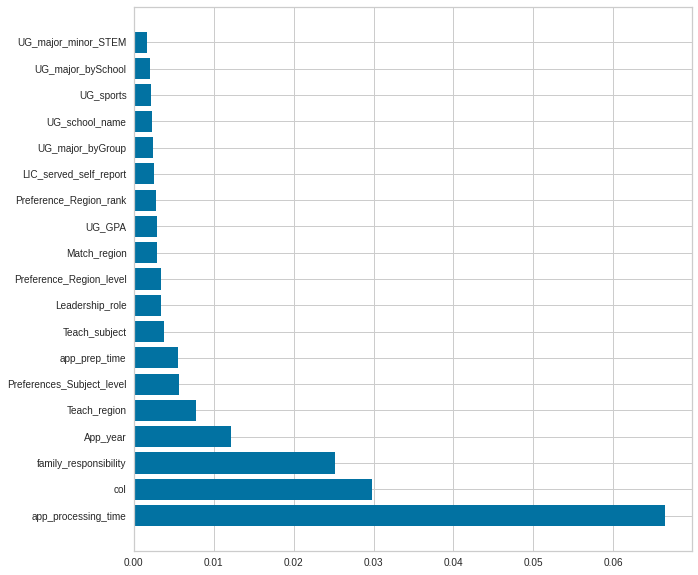

In [ ]:
feat_importances = pd.DataFrame(xgb_clf1.feature_importances_, index=X_train1.columns).reset_index().sort_values(0,ascending=False)[:200]
feat_importances['index']=feat_importances['index'].apply(lambda x: "_".join(x.split("_")[:-1]) if x not in data2.columns else x)
f1=feat_importances.groupby('index').mean()[0].reset_index().sort_values(0, ascending=False)
plt.figure(figsize=(10,10))
ax.grid(False)
plt.barh(f1['index'], f1[0])

In [ ]:
fets=f1['index'].tolist()
X_train1.columns
cols=[]
for i in fets:
  for j in X_train1.columns:
    if i in j:
       cols.append(j)
num_cols1=[i for i in num_cols if i in cols]
# xgb_clf2=model_build(XGBClassifier(colsample_bytree=0.8, gamma=2, max_depth=9, min_child_weight=10,
#               random_state=21, subsample=0.8),  X_train1[cols], y_train_p2, X_test1[cols], y_test_p2, num_cols1)

In [ ]:
df=data2.groupby(['Teach_region','App_year','app_processing_time','family_responsibility','Progress_6_Complete_2yrs']).count()['App_start_date'].reset_index(name='counts').sort_values('counts', ascending=False)
converted_cand_imp_traits=df[df['Progress_6_Complete_2yrs']==1]
dropped_cand_imp_traits=df[df['Progress_6_Complete_2yrs']==0]
converted_cand_imp_traits

,Teach_region,App_year,app_processing_time,family_responsibility,Progress_6_Complete_2yrs,counts
11318,NYC,2019,54.0,N,1,12
10888,NYC,2016,76.0,N,1,11
11154,NYC,2018,58.0,N,1,10
1161,BAYAREA,2016,76.0,N,1,9
10995,NYC,2017,61.0,N,1,9
...,...,...,...,...,...,...
5433,GNO,2018,104.0,N,1,1
5434,GNO,2018,107.0,Y,1,1
5436,GNO,2018,115.0,N,1,1
5438,GNO,2018,196.0,N,1,1


In [ ]:
dropped_cand_imp_traits

,Teach_region,App_year,app_processing_time,family_responsibility,Progress_6_Complete_2yrs,counts
1517,BAYAREA,2019,54.0,N,0,12
11168,NYC,2018,63.0,N,0,7
10986,NYC,2017,59.0,N,0,7
9545,MISSISSIPPI,2018,62.0,N,0,7
2766,CHICAGO,2016,82.0,N,0,6
...,...,...,...,...,...,...
5424,GNO,2018,91.0,N,0,1
5427,GNO,2018,94.0,N,0,1
5435,GNO,2018,109.0,Y,0,1
5437,GNO,2018,194.0,N,0,1


Clustering candidates based on important features to see interesting trends

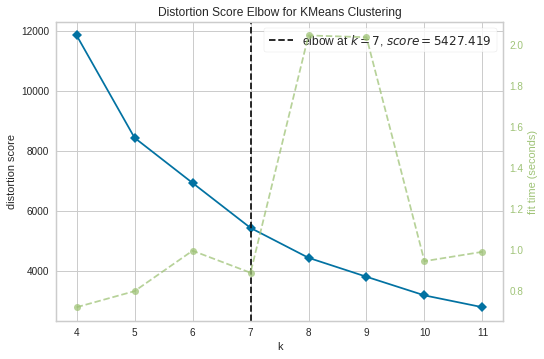

In [ ]:
vec1 = ColumnTransformer([('sc', StandardScaler(), num_cols1)], remainder='passthrough')
df1=vec1.fit_transform(X_train1[cols])
pca= PCA(2)
df2=pca.fit_transform(df1)
kmeans = KMeans(init='k-means++', n_init=10, max_iter=30)
req_clusters = KElbowVisualizer(kmeans, k=(4,12))
req_clusters.fit(df2)
req_clusters.show()

We ideally need 6 clusters, but lets start with two to understand the characteristics of each

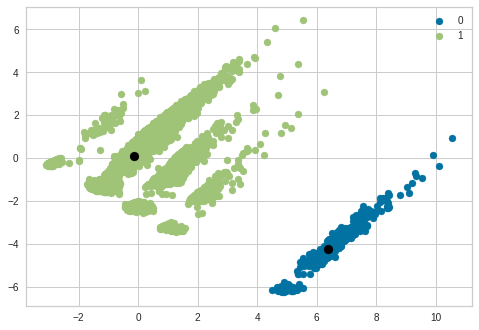

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300)
label = kmeans.fit_predict(df2)
# group1 = df2[label == 0]
# group2 = df2[label == 1]
# group3 = df2[label == 2]

#Plotting the results
labels = np.unique(label)
for i in labels:
    plt.scatter(df2[label == i , 0] , df2[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0] , kmeans.cluster_centers_[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df2, kmeans.labels_)
silhouette_avg

0.7965520820633388

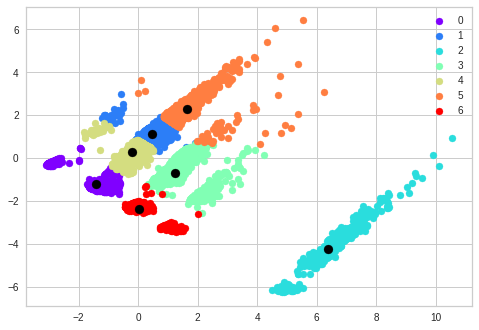

In [ ]:
import matplotlib.cm as cm
kmeans1 = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=300)
label = kmeans1.fit_predict(df2)
labels = np.unique(label)
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
for i,c in zip(labels,colors):
    plt.scatter(df2[label == i , 0] , df2[label == i , 1] , label = i, color=c)
plt.scatter(kmeans1.cluster_centers_[:,0] , kmeans1.cluster_centers_[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df2, kmeans1.labels_)
silhouette_avg

0.5965199943156239

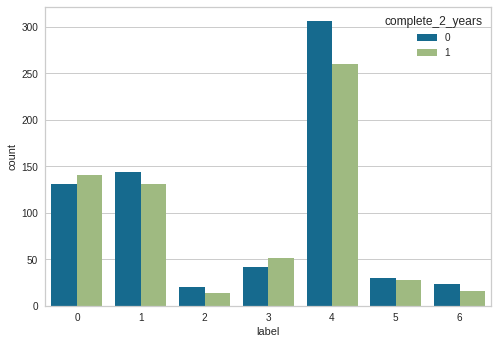

In [ ]:
X_train1['label']=label
X_train1['complete_2_years']=y_train_p2
sns.countplot(data=X_train1, x='label', hue='complete_2_years')

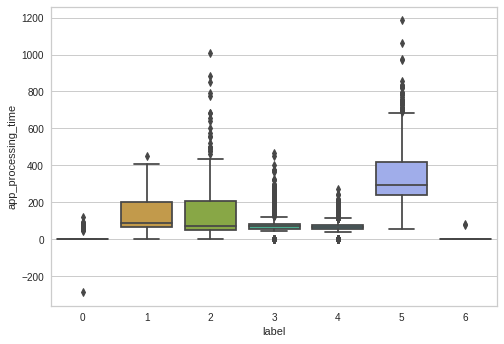

In [ ]:
proc_time=X_train1.groupby('label').mean()['app_processing_time'].reset_index()
sns.boxplot(data=X_train1, x='label', y='app_processing_time')

<Figure size 576x576 with 0 Axes>

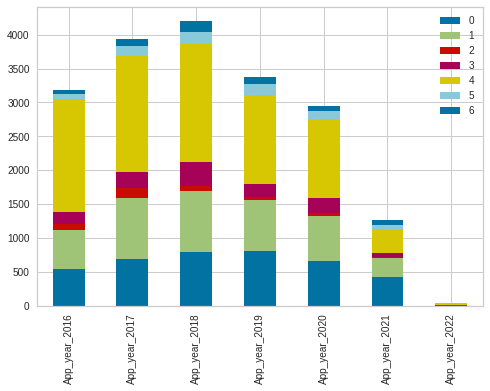

In [ ]:
proc_year=X_train1.groupby('label').sum()[[i for i in X_train1.columns if 'App_year' in i]].reset_index()
p1=proc_year.T[1:]
plt.figure(figsize=(8,8))
p1.plot(kind='bar', stacked=True)

# Part3: Impact of cost of living on candidate outcomes

In [ ]:
regions[~regions.Region.isin(data['Teach_region'])]
#No candidates to teach in orlando region

,Region,2016,2017,2018,2019,2020,2021,2022,2023
9,ORLANDO,5395.0,4420.0,4170.0,5125.0,5469.29,NaN,NaN,NaN


In [ ]:
data[~data.Teach_region.isin(regions['Region'])]['Teach_region'].unique()
#Cost of living info not available for 'CENTFLORIDA', 'TULSA'

array([nan, 'CENTFLORIDA', 'TULSA'], dtype=object)

In [ ]:
#top regions - We do all the following analysis for these top regions - regions that see the most number of applications
df_merged1=data_merged[data_merged.col.notnull()]
top_regions=df_merged1.groupby('Teach_region').count()['UG_school_name'].reset_index().sort_values('UG_school_name',ascending=False)[:10]['Teach_region'].tolist()
top_regions

['NYC',
 'BAYAREA',
 'LOSANGELES',
 'DALLAS',
 'BOSTONMETRO',
 'HOUSTON',
 'CHICAGO',
 'MEMPHIS',
 'CHARLOTTE',
 'BALTIMORE']

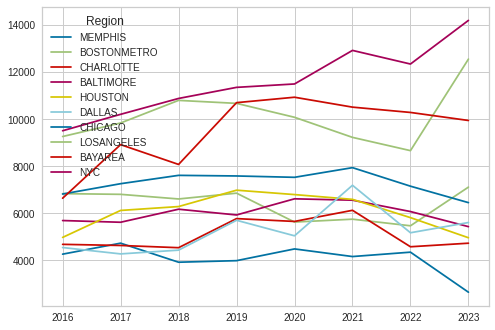

In [ ]:
#Cost of living in top states over the years
r=regions[regions.Region.isin(top_regions)].T
r.columns = r.iloc[0]
r.iloc[1:,0:10].plot()

In [ ]:
#scaling the no. of candidates with family responsibility becuase the #candidates with no family responsibility are higher in the data
def transform_row(row):
    if row['family_responsibility'] == 'N':
        row['candidates'] /= 5842
    else:
        row['candidates'] /= 1313
    return row

In [ ]:
g1=data2[['Teach_region','col','App_year','app_processing_time','Progress_6_Complete_2yrs','family_responsibility','user_ID']]
g2=g1.groupby(['Teach_region','col','App_year','family_responsibility','Progress_6_Complete_2yrs']).size().reset_index(name='candidates')
dropped=g2[g2['Progress_6_Complete_2yrs']==0]
dropped = dropped.apply(transform_row, axis=1)
dropped

,Teach_region,col,App_year,family_responsibility,Progress_6_Complete_2yrs,candidates
0,ALABAMA,4287.00,2016,N,0,0.001883
2,ALABAMA,4287.00,2016,Y,0,0.000762
4,ALABAMA,4745.00,2017,N,0,0.001712
6,ALABAMA,4745.00,2017,Y,0,0.002285
8,ALABAMA,5299.63,2021,N,0,0.000514
...,...,...,...,...,...,...
1021,WASHDC,6600.00,2016,Y,0,0.009901
1023,WASHDC,6752.14,2020,N,0,0.003252
1025,WASHDC,6752.14,2020,Y,0,0.003046
1027,WASHDC,8089.29,2021,N,0,0.002054


In [ ]:
dropped.groupby('family_responsibility').sum()['candidates']

family_responsibility
N    5842
Y    1313
Name: candidates, dtype: int64

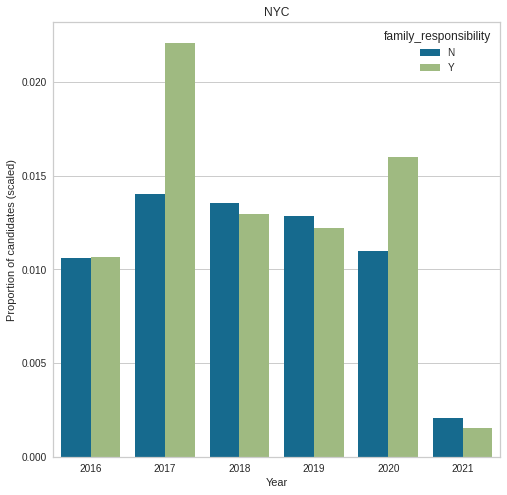

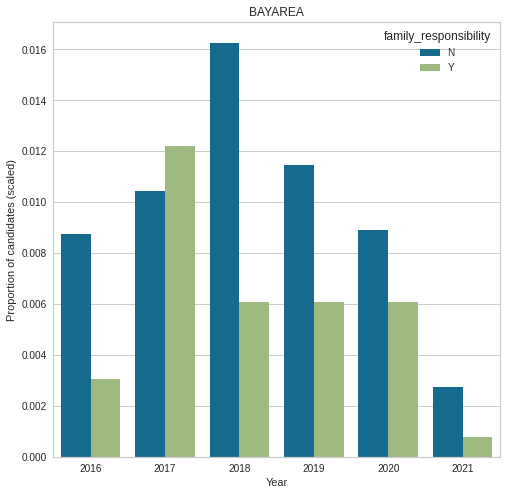

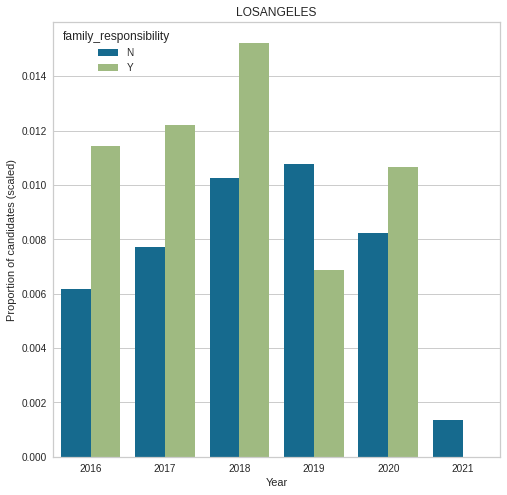

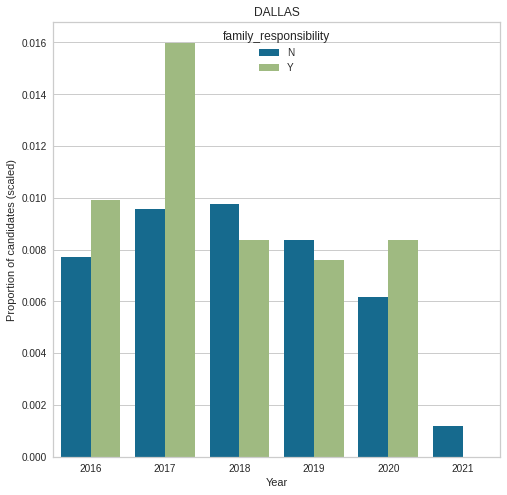

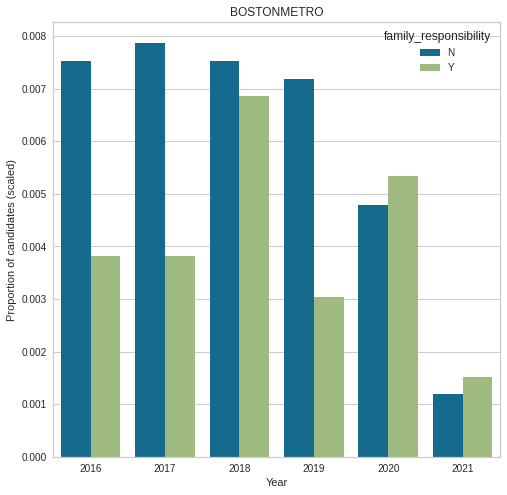

In [ ]:
#Taking proportion to make them comparable
for i in top_regions[:5]:
  city=dropped[dropped['Teach_region']==i]
  plt.figure(figsize=(8,8))
#sns.lineplot(data=nyc, x='col',y='successsful_candidates',hue='family_responsibility')
  plt.title(i)
  ax=sns.barplot(data=city, x='App_year',y='candidates',hue='family_responsibility')
  ax.set(xlabel='Year', ylabel='Proportion of candidates (scaled)')

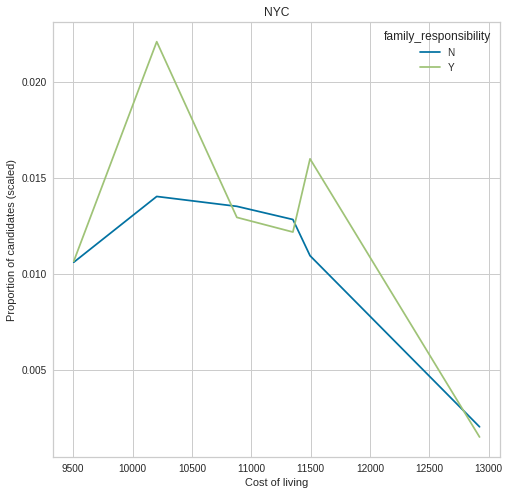

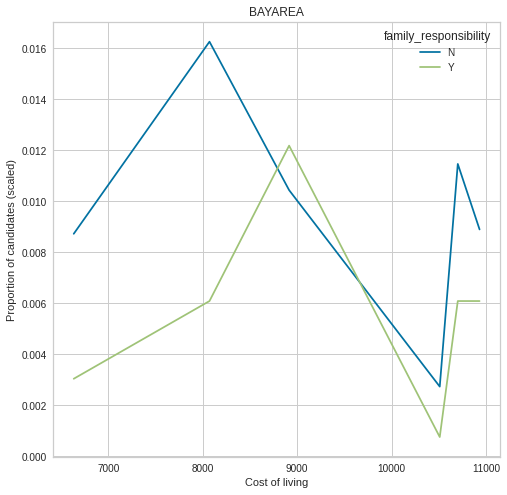

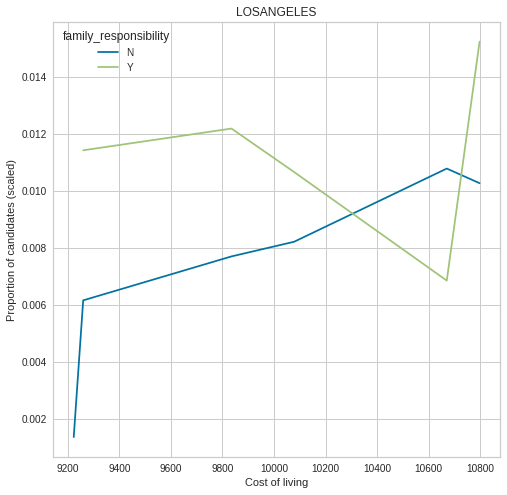

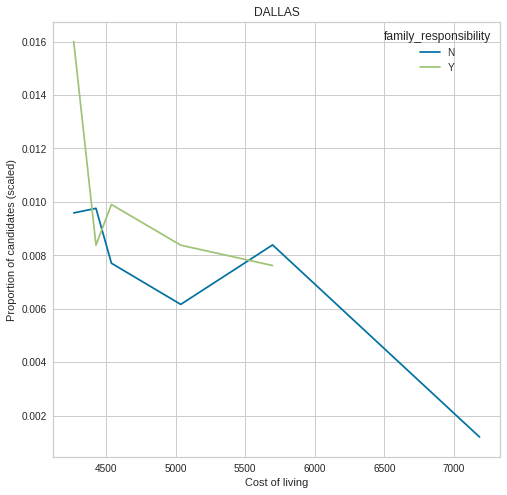

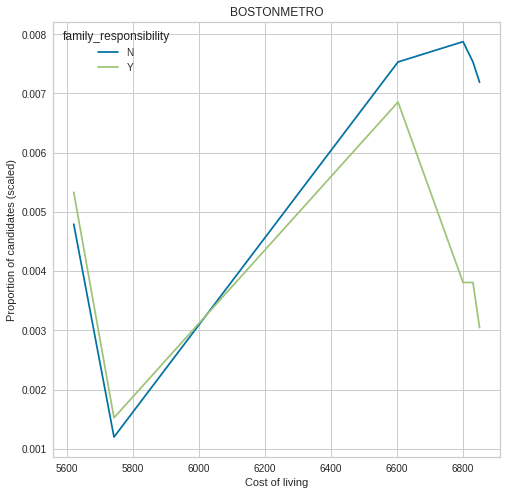

In [ ]:
for i in top_regions[:5]:
  city=dropped[dropped['Teach_region']==i]
  plt.figure(figsize=(8,8))
  plt.title(i)
  ax=sns.lineplot(data=city, x='col',y='candidates',hue='family_responsibility')
  ax.set(xlabel='Cost of living', ylabel='Proportion of candidates (scaled)')
  #sns.barplot(data=city, x='App_year',y='successsful_candidates',hue='family_responsibility')

# Part 4: How could TFA refine who they invite to interview
- Interview candidates similar to candidates who completed 2 years in previous years

In [ ]:
def feature_eng1(data):
  #Creating new meaningful features from the existing ones
  data['App_year']=data['App_year'].astype('category')
  data['App_submit_date']=pd.to_datetime(data['App_submit_date'])
  data['App_start_date']=pd.to_datetime(data['App_start_date'])
  data['ComfirmOffer_date']=pd.to_datetime(data['ComfirmOffer_date'])
  data['app_prep_time']=(data['App_submit_date']-data['App_start_date']).dt.days
  data['app_processing_time']=(data['ComfirmOffer_date']-data['App_submit_date']).dt.days
  data=data.drop(['App_submit_date','App_start_date','ComfirmOffer_date'], axis=1)
  data=data.drop(['SelectionDimension_1','SelectionDimension_2','SelectionDimension_3','SelectionDimension_4'], axis=1)

  cols = data.columns
  num_cols = data._get_numeric_data().columns
  cat_cols=list(set(cols) - set(num_cols))

  #Handling missing values
  for i in num_cols:
    data[i].fillna(0, inplace=True)

  for i in cat_cols:
    data[i]=data[i].astype('category')
    data[i].cat.add_categories(['NA'], inplace=True)
    data[i].fillna('NA', inplace=True)
    data[i]=data[i].astype('category')

  return data, cat_cols, num_cols

def process_data1(X):
  X_eng, cat_cols, num_cols =feature_eng1(X)
  X_nom, nom_enc=handle_nominal_train(X_eng,cat_cols)
  X_out=X_nom.drop(cat_cols, axis=1)
  print(X_out.shape)
  return X_out

In [ ]:
df3=data.drop(['Progress_1_Invite_Intrvw','Progress_2_Complete_Intrvw','Progress_3_Accepted_toCorp','Progress_4_Comfirm_Offer','Progress_5_Start_1stDay'], axis=1)
df_curr=df3[df3['App_year']==df3['App_year'].max()]
df_prev=df3[df3['App_year']!=df3['App_year'].max()]
df_prev=df_prev[df_prev['Progress_6_Complete_2yrs']=='TRUE']
df_curr_list=df_curr.user_ID.unique().tolist()
df_prev_list=df_prev.user_ID.unique().tolist()
data3=pd.concat([df_prev, df_curr], axis=0)

In [ ]:
data4 =process_data1(data3)
data4.drop('index',axis=1,inplace=True)
data4.head()

(24589, 349)


,user_ID,UG_GPA,Preference_Region_level,Preference_Region_rank,Preferences_Subject_level,app_prep_time,app_processing_time,LIC_served_rating_LEVEL1,LIC_served_rating_LEVEL2,LIC_served_rating_LEVEL3,...,UG_sports_Y,App_year_2016,App_year_2017,App_year_2018,App_year_2019,App_year_2020,App_year_2021,App_year_2022,UG_major_minor_STEM_N,UG_major_minor_STEM_Y
0,8077374,3.82,1.0,1.0,1.0,0.0,53.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7122565,4.00,1.0,1.0,1.0,20.0,68.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7567084,3.03,1.0,2.0,1.0,0.0,101.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6622178,3.19,1.0,1.0,2.0,8.0,81.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9495415,3.22,1.0,1.0,1.0,0.0,70.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
users_ids=data4[['user_ID']]
data4.drop('user_ID',axis=1,inplace=True)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_cosine = cosine_similarity(data4)
pd.DataFrame(user_similarity_cosine)

,0,1,2,3,4,5,6,7,8,9,...,24579,24580,24581,24582,24583,24584,24585,24586,24587,24588
0,1.000000,0.956779,0.997076,0.992407,0.998391,0.997397,0.980059,0.995040,0.974368,0.996215,...,0.064192,0.064511,0.031312,0.057017,0.045835,0.035903,0.003503,0.063364,0.059058,0.060819
1,0.956779,1.000000,0.957516,0.980604,0.957379,0.956659,0.992913,0.954585,0.995132,0.957197,...,0.042069,0.042379,0.253232,0.049565,0.187723,0.258668,0.283100,0.096983,0.040053,0.052394
2,0.997076,0.957516,1.000000,0.993859,0.998691,0.997046,0.980671,0.995078,0.975770,0.997310,...,0.026902,0.028830,0.012659,0.023150,0.018531,0.013193,0.001301,0.028325,0.022778,0.025118
3,0.992407,0.980604,0.993859,1.000000,0.994025,0.992610,0.993377,0.989589,0.991398,0.993548,...,0.036880,0.037041,0.098450,0.034487,0.075755,0.102917,0.099937,0.053949,0.034258,0.034668
4,0.998391,0.957379,0.998691,0.994025,1.000000,0.997456,0.980372,0.994770,0.975733,0.997456,...,0.048349,0.045914,0.022464,0.037735,0.028069,0.024388,0.002101,0.040015,0.040051,0.037967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24584,0.035903,0.258668,0.013193,0.102917,0.024388,0.033874,0.176008,0.030234,0.196507,0.025149,...,0.469978,0.470270,0.938142,0.450456,0.789745,1.000000,0.861104,0.612466,0.483121,0.431803
24585,0.003503,0.283100,0.001301,0.099937,0.002101,0.003471,0.184500,0.002980,0.212425,0.002621,...,0.041352,0.043138,0.830991,0.044755,0.541227,0.861104,1.000000,0.222963,0.045625,0.041365
24586,0.063364,0.096983,0.028325,0.053949,0.040015,0.056883,0.080325,0.062989,0.075929,0.047092,...,0.787261,0.853733,0.597448,0.818974,0.783757,0.612466,0.222963,1.000000,0.832379,0.852944
24587,0.059058,0.040053,0.022778,0.034258,0.040051,0.052303,0.039378,0.052241,0.037476,0.046768,...,0.809325,0.809628,0.449464,0.845948,0.657949,0.483121,0.045625,0.832379,1.000000,0.772723


In [ ]:
l1=users_ids[users_ids['user_ID'].isin(df_curr_list)].index.tolist()
users=pd.DataFrame(user_similarity_cosine)
users1=users.drop(l1,axis=1)
users1

,0,1,2,3,4,5,6,7,8,9,...,12433,12434,12435,12436,12437,12438,12439,12440,12441,12442
0,1.000000,0.956779,0.997076,0.992407,0.998391,0.997397,0.980059,0.995040,0.974368,0.996215,...,0.759806,0.756815,0.995670,0.997703,0.977001,0.997139,0.989407,0.995652,0.880349,0.996748
1,0.956779,1.000000,0.957516,0.980604,0.957379,0.956659,0.992913,0.954585,0.995132,0.957197,...,0.911570,0.909916,0.957383,0.957568,0.995050,0.957658,0.985061,0.968856,0.977306,0.957105
2,0.997076,0.957516,1.000000,0.993859,0.998691,0.997046,0.980671,0.995078,0.975770,0.997310,...,0.760382,0.757805,0.999195,0.998237,0.978436,0.998658,0.991247,0.995440,0.881652,0.997334
3,0.992407,0.980604,0.993859,1.000000,0.994025,0.992610,0.993377,0.989589,0.991398,0.993548,...,0.820413,0.818382,0.993634,0.993621,0.993310,0.994053,0.998366,0.995682,0.922821,0.993063
4,0.998391,0.957379,0.998691,0.994025,1.000000,0.997456,0.980372,0.994770,0.975733,0.997456,...,0.760515,0.757863,0.997978,0.998256,0.978219,0.998750,0.990800,0.996102,0.880885,0.997817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24584,0.035903,0.258668,0.013193,0.102917,0.024388,0.033874,0.176008,0.030234,0.196507,0.025149,...,0.562454,0.563867,0.006352,0.028057,0.182911,0.023961,0.123707,0.075294,0.411527,0.030652
24585,0.003503,0.283100,0.001301,0.099937,0.002101,0.003471,0.184500,0.002980,0.212425,0.002621,...,0.648745,0.651456,0.000625,0.002899,0.201250,0.002106,0.124416,0.053628,0.469761,0.002662
24586,0.063364,0.096983,0.028325,0.053949,0.040015,0.056883,0.080325,0.062989,0.075929,0.047092,...,0.151899,0.150375,0.012592,0.055209,0.067033,0.040114,0.063433,0.067519,0.122435,0.050701
24587,0.059058,0.040053,0.022778,0.034258,0.040051,0.052303,0.039378,0.052241,0.037476,0.046768,...,0.038077,0.031995,0.010991,0.048927,0.026786,0.040059,0.039446,0.061146,0.033627,0.057384


In [ ]:
df_sim_users=pd.DataFrame(users1.iloc[l1].mean()).sort_values(0, ascending=False)

,0
365,0.412945
11912,0.412524
2466,0.411379
11461,0.411315
1606,0.410896
...,...
249,0.095790
1067,0.095400
12214,0.093457
6495,0.091782


Select top n from the above list where n is based on previous drop off between #interviewed to #completed_2_yrs:

No. of people to be interviewd=7.14*sourcing_target